In [2]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 5.7 MB/s eta 0:00:00


In [3]:
!pip install itables

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.9 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LassoCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import matplotlib.pyplot as plt

import itables
from itables import show

In [ ]:
path = 'data_eda.csv'
data = pd.read_csv(path).drop(columns=['Unnamed: 0', 'IC50, mM', 'CC50, mM'], axis=1)
data.head(3)

,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,MaxPartialCharge,MinPartialCharge,FpDensityMorgan1,BCUT2D_MWHI,...,fr_piperdine,fr_piperzine,fr_priamide,fr_pyridine,fr_quatN,fr_sulfide,fr_thiazole,fr_thiophene,fr_unbrch_alkane,SI
0,5.094096,0.387225,0.387225,0.417362,42.928571,384.652,0.038844,-0.293526,0.642857,14.822266,...,0,0,0,0,0,0,0,0,3,28.125
1,3.961417,0.533868,0.533868,0.462473,45.214286,388.684,0.012887,-0.313407,0.607143,14.975110,...,0,0,0,0,0,0,0,0,3,7.000
2,2.627117,0.543231,0.543231,0.260923,42.187500,446.808,0.094802,-0.325573,0.562500,15.353938,...,0,0,0,0,2,0,0,0,3,0.720


In [6]:
show(data.corr()['SI'])

Loading ITables v2.4.2 from the internet... (need help?)


Я не стала отбирать выбросы у индекса селективности, поскольку это очень сильно снижало метрики. К тому же, это классификация, и небольшое количество выбросов так сильно не влияет на предсказание, как если бы речь шла о регрессии. Также я применила логарифмирование, поскольку это улучшает распределение целевой (и метрики).

In [7]:
data['SI'] = data['SI'].apply(np.log)
X = data.drop('SI', axis=1)
y = data['SI']

# Разделение на трейн/тест
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
def define_target_value(value):
  if value > np.log(8):
    return 1

  return 0

#median = y_train.median()
y_train = y_train.apply(define_target_value)
y_test = y_test.apply(define_target_value)

In [9]:
data['target'] = data['SI'].apply(define_target_value)

In [10]:
def correlation_feature_selections(df, target_col, threshold=0.1):
    # Оставляем только числовые признаки
    df_numeric = df.select_dtypes(include=[float, int])

    # Вычисляем корреляции с целевой переменной
    correlations = df_numeric.corr()[target_col].abs().sort_values(ascending=False)

    # Отбираем признаки с корреляцией выше порога
    selected_features = correlations[correlations > threshold].index.tolist()
    selected_features.remove(target_col)  # удаляем целевую переменную из признаков

    print(f"Выбранные признаки ({len(selected_features)}): {selected_features}")
    return selected_features

In [11]:
selected_features_by_corr = correlation_feature_selections(data.drop('SI', axis=1), target_col='target')

Выбранные признаки (21): ['fr_Imine', 'NumAliphaticHeterocycles', 'NumSaturatedHeterocycles', 'MaxAbsEStateIndex', 'fr_allylic_oxid', 'VSA_EState5', 'SMR_VSA4', 'VSA_EState4', 'fr_Ndealkylation1', 'MinEStateIndex', 'SMR_VSA5', 'fr_NH2', 'MaxPartialCharge', 'EState_VSA6', 'fr_priamide', 'SlogP_VSA3', 'EState_VSA8', 'PEOE_VSA14', 'VSA_EState7', 'fr_nitro', 'BCUT2D_MWLOW']


In [12]:
def random_forest_feature_selection(df, target_col, n_top=20):
    X = df.drop(columns=[target_col])
    y = df[target_col]

    # Разделение на трейн/тест
    X_train, _, y_train, _ = train_test_split(X, y, test_size=0.2, random_state=42)

    # Обучаем модель
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Получаем важность признаков
    importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

    # Выводим топ-N самых важных
    top_features = importance.head(n_top).index.tolist()
    print(f"Топ-{n_top} важных признаков:\n", top_features)

    # График важности
    importance.nlargest(n_top).plot(kind='barh', figsize=(10, 8))
    plt.title("Feature Importance")
    plt.show()

    return top_features

Топ-10 важных признаков:
 ['VSA_EState4', 'MaxAbsEStateIndex', 'qed', 'BCUT2D_MRLOW', 'MinPartialCharge', 'EState_VSA8', 'SPS', 'BCUT2D_CHGLO', 'MinAbsEStateIndex', 'FpDensityMorgan1']


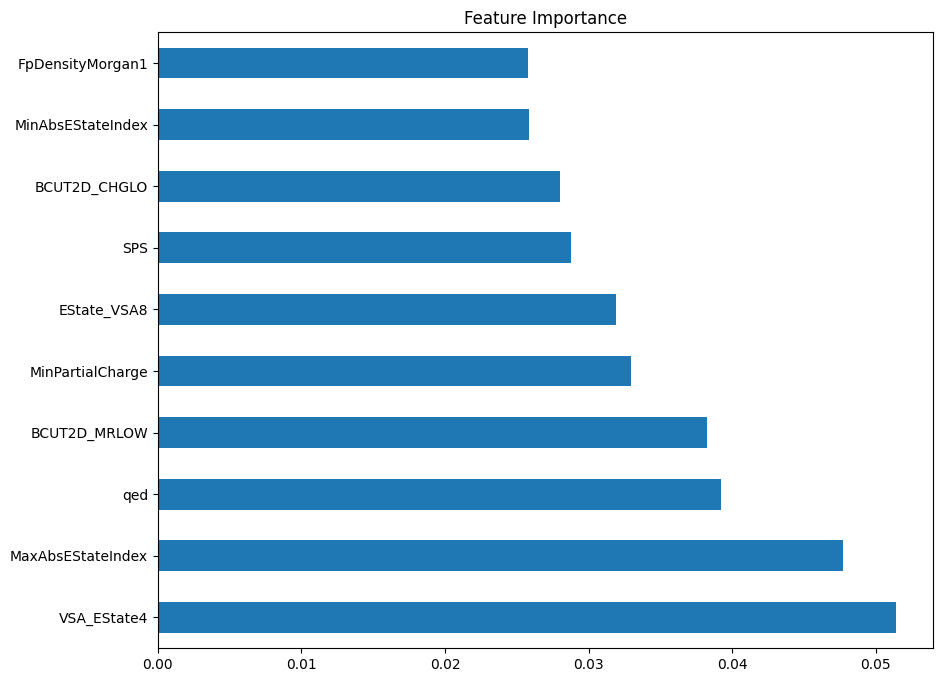

In [13]:
selected_features_by_rand_for = random_forest_feature_selection(data.drop('SI', axis=1), target_col='target', n_top=10)

In [14]:
def lasso_feature_selection(df, target_col):
    X = df.drop(columns=[target_col])
    y = df[target_col]

    # Стандартизируем данные
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Подбор оптимального alpha и обучение Lasso
    model = LassoCV(cv=5, random_state=42, max_iter=10000)
    model.fit(X_scaled, y)

    # Определяем, какие признаки не занулены
    coef = pd.Series(model.coef_, index=X.columns)
    selected_features = coef[coef != 0].index.tolist()

    print(f"Коэффициенты:\n{coef.sort_values(ascending=False)}")
    print(f"Оставлено признаков: {len(selected_features)}")
    print("Оставленные признаки:", selected_features)

    return selected_features

In [15]:
selected_features_by_lasso = lasso_feature_selection(data.drop('SI', axis=1), target_col='target')

Коэффициенты:
fr_Imine                    0.065254
SMR_VSA6                    0.047159
fr_NH1                      0.044132
FpDensityMorgan1            0.041673
fr_priamide                 0.039030
                              ...   
SlogP_VSA3                 -0.027342
fr_nitro                   -0.027612
MinPartialCharge           -0.040936
fr_allylic_oxid            -0.057654
NumSaturatedHeterocycles   -0.080568
Length: 94, dtype: float64
Оставлено признаков: 46
Оставленные признаки: ['MaxAbsEStateIndex', 'MinEStateIndex', 'SPS', 'MinPartialCharge', 'FpDensityMorgan1', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'PEOE_VSA14', 'PEOE_VSA3', 'PEOE_VSA5', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA5', 'SMR_VSA6', 'SlogP_VSA3', 'SlogP_VSA7', 'SlogP_VSA8', 'EState_VSA11', 'EState_VSA2', 'VSA_EState5', 'NumSaturatedHeterocycles', 'fr_Al_COO', 'fr_ArN', 'fr_C_S', 'fr_Imine', 'fr_NH1', 'fr_NH2', 'fr_Ndealkylation1', 'fr_allylic_oxid', 'fr_bicyclic', 'fr_epoxide', 'fr_furan', 'fr_hdrzone', 'fr_imidazole', 'fr_i

# Подбор гиперпарметров

In [16]:
def get_models():
  return {
      "Logistic Regression": {
          "model": LogisticRegression(),
          "params": {
              'C': [0.01, 0.1, 1, 10, 100],
              'penalty': ['l1', 'l2'],
              'solver': ['liblinear']
          }
      },
      "Random Forest": {
          "model": RandomForestClassifier(random_state=42),
          "params": {
              'n_estimators': [50, 100, 200],
              'max_depth': [None, 5, 10, 20],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4],
              'criterion': ['gini', 'entropy']
          }
      },
      "Gradient Boosting": {
          "model": GradientBoostingClassifier(random_state=42),
          "params": {
              'n_estimators': [50, 100, 200],
              'learning_rate': [0.01, 0.1, 0.2],
              'max_depth': [3, 5, 7],
              'subsample': [0.8, 1.0],
              'min_samples_split': [2, 5]
          }
      },
      "XGBoost": {
          "model": XGBClassifier(random_state=42, eval_metric='logloss'),
          "params": {
              'n_estimators': [50, 100, 200],
              'learning_rate': [0.01, 0.1, 0.2],
              'max_depth': [3, 5, 7],
              'colsample_bytree': [0.7, 1.0],
              'subsample': [0.8, 1.0]
          }
      },
      "CatBoost": {
          "model": CatBoostClassifier(random_seed=42, verbose=0),
          "params": {
              'iterations': [100, 200],
              'learning_rate': [0.01, 0.05, 0.1],
              'depth': [4, 6, 8],
              'l2_leaf_reg': [1, 3, 5, 7]
          }
      },
      "KNN": {
          "model": KNeighborsClassifier(),
          "params": {
              'n_neighbors': [3, 5, 7, 10],
              'weights': ['uniform', 'distance'],
              'p': [1, 2]  # 1 - Manhattan, 2 - Euclidean
          }
      }
  }

In [17]:
def start_classification(X_train_final, X_test_final):
  models = get_models()
  results = []

  for model_name, config in models.items():
      print(f"\nОбучение модели: {model_name}")

      if not config['params']:  # если нет параметров для подбора
          model = config['model']
          model.fit(X_train_final, y_train)
          best_params = {}
      else:
          # Используем Accuracy как основную метрику для подбора гиперпараметров
          grid = GridSearchCV(config['model'], config['params'], cv=5, scoring='accuracy', n_jobs=-1)
          grid.fit(X_train_final, y_train)
          model = grid.best_estimator_
          best_params = grid.best_params_

      # Предсказания
      y_pred = model.predict(X_test_final)

      # Для ROC AUC нужен predict_proba (если модель его поддерживает)
      if hasattr(model, "predict_proba"):
          y_proba = model.predict_proba(X_test_final)[:, 1]
      else:
          y_proba = None

      # Метрики
      accuracy = accuracy_score(y_test, y_pred)
      precision = precision_score(y_test, y_pred)
      recall = recall_score(y_test, y_pred)
      f1 = f1_score(y_test, y_pred)

      # Если есть вероятности, считаем ROC AUC
      if y_proba is not None:
          roc_auc = roc_auc_score(y_test, y_proba)
      else:
          roc_auc = None

      results.append({
          "Model": model_name,
          "Best Params": best_params,
          "Accuracy": accuracy,
          "Precision": precision,
          "Recall": recall,
          "F1 Score": f1,
          "ROC AUC": roc_auc
      })

      print(f"Лучшие параметры: {best_params}")
      print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
      if roc_auc is not None:
          print(f"ROC AUC: {roc_auc:.4f}")
  return results

# Результаты

In [18]:
X_train_final = X_train[selected_features_by_corr]
X_test_final = X_test[selected_features_by_corr]
scaler = StandardScaler()
X_train_final = scaler.fit_transform(X_train_final)
X_test_final = scaler.fit_transform(X_test_final)
res1 = start_classification(X_train_final, X_test_final)


Обучение модели: Logistic Regression
Лучшие параметры: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy: 0.6392, Precision: 0.4921, Recall: 0.4493, F1: 0.4697
ROC AUC: 0.6110

Обучение модели: Random Forest
Лучшие параметры: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Accuracy: 0.6701, Precision: 0.5581, Recall: 0.3478, F1: 0.4286
ROC AUC: 0.6437

Обучение модели: Gradient Boosting
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 50, 'subsample': 0.8}
Accuracy: 0.6649, Precision: 0.5500, Recall: 0.3188, F1: 0.4037
ROC AUC: 0.6391

Обучение модели: XGBoost
Лучшие параметры: {'colsample_bytree': 0.7, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
Accuracy: 0.6443, Precision: 0.5000, Recall: 0.3913, F1: 0.4390
ROC AUC: 0.6375

Обучение модели: CatBoost
Лучшие параметры: {'depth': 6, 'iterations': 200, 'l2_leaf_reg': 7, 'learning_rate': 

In [19]:
X_train_final = X_train[selected_features_by_lasso]
X_test_final = X_test[selected_features_by_lasso]
scaler = StandardScaler()
X_train_final = scaler.fit_transform(X_train_final)
X_test_final = scaler.fit_transform(X_test_final)
res2 = start_classification(X_train_final, X_test_final)


Обучение модели: Logistic Regression
Лучшие параметры: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy: 0.6907, Precision: 0.5763, Recall: 0.4928, F1: 0.5312
ROC AUC: 0.7184

Обучение модели: Random Forest
Лучшие параметры: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 50}
Accuracy: 0.6701, Precision: 0.5758, Recall: 0.2754, F1: 0.3725
ROC AUC: 0.6941

Обучение модели: Gradient Boosting
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 50, 'subsample': 1.0}
Accuracy: 0.6701, Precision: 0.5556, Recall: 0.3623, F1: 0.4386
ROC AUC: 0.6958

Обучение модели: XGBoost
Лучшие параметры: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
Accuracy: 0.6804, Precision: 0.6296, Recall: 0.2464, F1: 0.3542
ROC AUC: 0.7014

Обучение модели: CatBoost
Лучшие параметры: {'depth': 8, 'iterations': 200, 'l2_leaf_reg': 1, 'learning_rate': 

In [20]:
X_train_final = X_train[selected_features_by_rand_for]
X_test_final = X_test[selected_features_by_rand_for]
scaler = StandardScaler()
X_train_final = scaler.fit_transform(X_train_final)
X_test_final = scaler.fit_transform(X_test_final)
res3 = start_classification(X_train_final, X_test_final)


Обучение модели: Logistic Regression


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Лучшие параметры: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy: 0.6443, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
ROC AUC: 0.5000

Обучение модели: Random Forest
Лучшие параметры: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy: 0.7113, Precision: 0.6512, Recall: 0.4058, F1: 0.5000
ROC AUC: 0.6825

Обучение модели: Gradient Boosting
Лучшие параметры: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 200, 'subsample': 0.8}
Accuracy: 0.6546, Precision: 0.5385, Recall: 0.2029, F1: 0.2947
ROC AUC: 0.6644

Обучение модели: XGBoost
Лучшие параметры: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Accuracy: 0.6701, Precision: 0.6190, Recall: 0.1884, F1: 0.2889
ROC AUC: 0.6823

Обучение модели: CatBoost
Лучшие параметры: {'depth': 8, 'iterations': 100, 'l2_leaf_reg': 3, 'learning_rate': 0.05}
Accuracy: 0.7010, Precisi

Лучше всего себя показала модель KNN, обученная на признаках, отобранных при помощи Лассо. Она пропускает меньше препаратов с высоким индексом селективности в отличие от других, и у нее лучший баланс между Precision и Recall с приемлемой точностью.

Ее гиперпараметры:
-	n_neighbors: 5
-	p: 1
-	weights: distance

Ее метрики:
-	Accuracy: 0,6443
-	Precision: 0,5000
-	Recall: 0,5217
-	F1: 0,5106
-	ROC AUC: 0,6547
